In [1]:
# imports
import numpy as np
from numpy import loadtxt as loadtxt

import matplotlib.pyplot as plt

import torch
from tqdm import tqdm

from haloidp_analysis import minimize,profile_likelihood,plot_eta,convert_params_to_fit_to_halo_id

In [2]:
# set device

device = "cuda"
type_torch = torch.double

In [12]:
# load in data

# Si data
fpath_si = f'./halo_independent/mock_data/ModelAnsh10MeV_Si.csv'
fake_data_si = loadtxt(fpath_si,delimiter=',') # shape: (10,2)
rates_si = fake_data_si[:,1]
rates_si = torch.from_numpy(rates_si).to(device)

"""
# Ge data
fpath_ge = f'./halo_independent/1kgyr_fake_data/Model{modelnumber}_Ge.csv'
fake_data_ge = loadtxt(fpath_ge,delimiter=',')
rates_ge = fake_data_ge[:,1]
rates_ge = torch.from_numpy(rates_ge).to(device)

print(fake_data_si.shape, fake_data_si.shape)
"""
observed_rates = [rates_si]

We want to enforce that the steps are monotonically decreasing. So it might be easier to parameterize the *differences* between steps, and then enforce that all of these differences are stricly negative.

`learnable_weights`: the object that PyTorch optimizes.

`halo_id_params = -np.cumsum(learnable_weights**2)` will be monotonically decreasing, no matter what `learnable_weights` is.


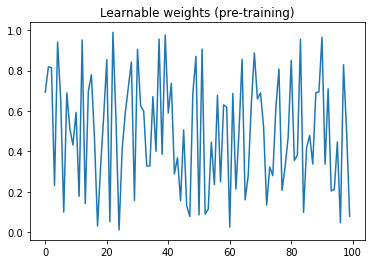

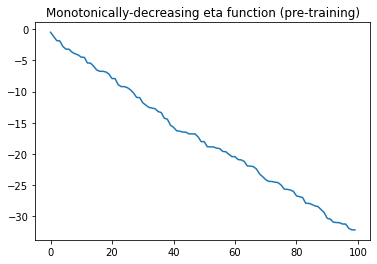

In [13]:
# bin over a few mX choices
num_steps = 100
coarse_mX_grid = torch.arange(5,20,step=5).numpy()#torch.concatenate((torch.arange(5,50,step=5))).numpy()#,torch.arange(100,1100,step=200))).numpy()


all_results = []\


# instead of learning the function 

# TODO change this to be less spiky maybe?
def initialization_function(x, a = 2, b = 8):
    return -a*x - b

learnable_weights = []
x = np.linspace(0, 1, num_steps)
for m in range(len(coarse_mX_grid)):
    # random initialization for each mass
    learnable_weights.append(torch.rand(num_steps,dtype=type_torch,device=device))
    #initial_halo_velocities.append(torch.tensor(initialization_function(x),dtype=type_torch,device=device))
    
plt.figure()
plt.plot(learnable_weights[m].cpu())
plt.title("Learnable weights (pre-training)")
plt.show()

plt.figure()
plt.plot(convert_params_to_fit_to_halo_id(learnable_weights[m]).cpu())
plt.title("Monotonically-decreasing eta function (pre-training)")
plt.show()



100%|██████████| 1500/1500 [00:13<00:00, 111.17it/s]


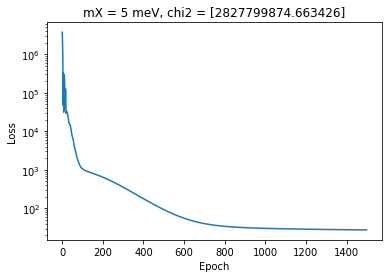

100%|██████████| 1500/1500 [00:13<00:00, 111.61it/s]


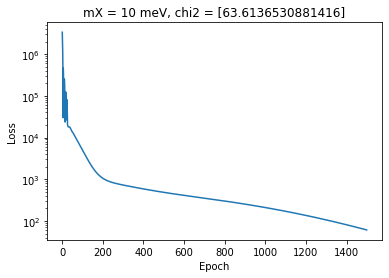

100%|██████████| 1500/1500 [00:13<00:00, 109.88it/s]


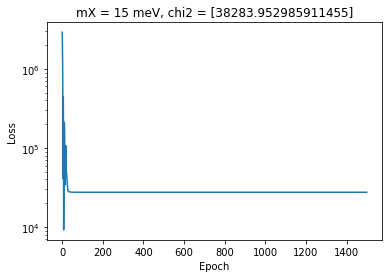

In [14]:
for FDMn in [0]:
    loc_results  = []
    for m in range(len(coarse_mX_grid)):
        mX = coarse_mX_grid[m]
        params_to_fit = learnable_weights[m].detach().clone().to(device)

        materials = ['Si']
        params_, losses_,test_stats_ =  minimize(mX, FDMn, observed_rates, materials, profile_likelihood, params_to_fit, epochs=1500,
                                                     lr=0.1, device=device, optimizer_algorithm='Adam', adaptive=True, alpha = 0)

        loc_results.append([mX, params_, losses_, test_stats_])
        
        plt.figure()
        plt.plot(losses_)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.yscale("log")

        plt.title(f"mX = {mX} meV, chi2 = {test_stats_}")
        plt.show()
        
        
        
    all_results.append(loc_results)

si best fit at 10


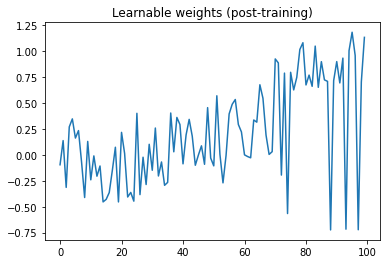

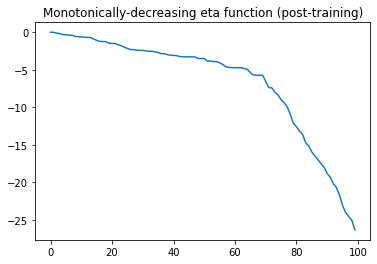

In [15]:
tien_halo_params = [220.0,232,544,0.4e9]
ts_si = []
index = 0
for i,mX in enumerate(coarse_mX_grid):
    # params = stuff[i][0]
    s = all_results[index][i][3]
    ts_si.append(s[0])


bfi_Si= np.argmin(ts_si)
print(f'si best fit at {coarse_mX_grid[bfi_Si]}')
best_fit_params = all_results[index][bfi_Si][1]



plt.figure()
plt.plot(best_fit_params.cpu().detach().numpy())
plt.title("Learnable weights (post-training)")
plt.show()

plt.figure()
plt.plot(convert_params_to_fit_to_halo_id(best_fit_params).cpu().detach().numpy())
plt.title("Monotonically-decreasing eta function (post-training)")
plt.show()


(array([2.49198272e-15, 2.49198272e-15, 2.49198272e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([2.73871474e-15, 2.73259055e-15, 2.72646248e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

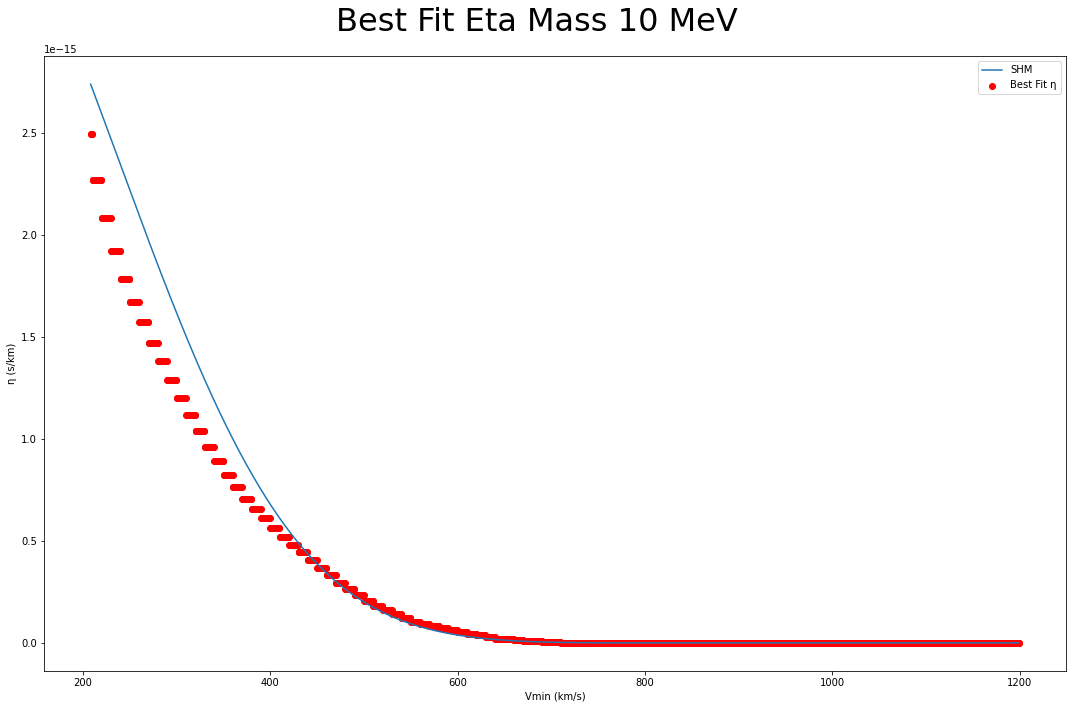

In [16]:

plot_eta(coarse_mX_grid[bfi_Si],convert_params_to_fit_to_halo_id(best_fit_params),plot_mb=True,device=best_fit_params.device,save=False,cross_section=1e-37,halo_params=tien_halo_params,norm=1e-15)
